# Dashboard zur Auswertung von Rezepten

Grundlage sind die Datenbank Spoonacular sowie der Subreddit "food"

### Use Cases:
##### Reddit:
1. Postzeit (Uhrzeit) der besten Posts
2. Postzeit (Uhrzeit) der schlechtesten Posts
3. längste Zeit in Top
4. kürzeste Zeit in Top(?)
5. Länge des Titels in Bezug auf Ups/Dauer in Top
6. Kategorisierung mit NLP bzgl. Süß/Herzhaftes Gericht
7. Kategorisierung mit Bilderkennung bzgl. Süß/Herzhaftes Gericht
8. Up’s abhängig von Autor
9. Anzahl der Kommentare in Abhängigkeit von Ups
10. Anzahl der Kommentare in Abhängigkeit von Postzeit
11. Anzahl der Kommentare in Abhängigkeit von Autor
12. Anzahl der Kommentare über die Zeit
13. Anzahl der Ups über die Zeit
14. Kommentare: 
    1. Beziehung zwischen Personen erkennen/clustern


    
##### Spoonacular:
15. Anteil vegane/vegetarische/fleischlastige Gerichte
16. Anteil laktosefreie Gerichte
17. Anteil glutenfreier Gerichte
18. Bewertung im Verhältnis zu Inhaltsstoffen
    1. Zucker    
    2. Fett
    3. Kalorien
19. Zubereitungszeit in Abhängigkeit von Likes
20. Kategorisierung aufgrund von Inhaltsstoffen
21. Zubereitungszeit in Abhängigkeit von Kategorie 


##### Kombi:
22. Kombi aus Spoonacular Nr. 17 und Top 10 der letzten 24h
23. Vergleich der Beliebtheit der Rezepte: Spoonacular Likes vs. Reddit Ups


## Requirements

In [1]:
# Final Variablen
API_KEY_SPOONACULAR = "146fe79a630b4afb8306a2985bedc64c"
API_KEY_SPOONACULAR = "6e0a91c81983423792b327bc4b78bb1d"

API_KEY_REDDIT = "KAJ2xGzCOlH3hyTRADNdSBDuTBORvw"
API_CLIENTID_REDDIT = "tSemvcUBRFCTYQ"

USERNAME_REDDIT = "Short-Arrival7632"
PW_REDDIT = "cookies123"

In [2]:
# KONFIGURATION

LIMIT_REDDIT_POSTS = 100
LIMIT_SPOONACULAR_RECIPES = 100
REDDIT_SAVE_INTERVALL = 10 # Minuten

In [ ]:
# Auf Windows ausführen (einmalig)
!pip install praw
!pip install pandas
!pip install matplotlib
!pip install mysql-connector-python

In [ ]:
# Auf Linux ausführen (einmalig)
"""
!pip3 install praw
!pip3 install pandas
!pip3 install matplotlib
!pip3 install mysql-connector-python
"""

In [3]:
import praw
import pandas as pd
from datetime import datetime, timedelta
import requests
import json
import matplotlib.pyplot as plt
import matplotlib.dates as pdt
import mysql.connector
import re

### Connect to Database

In [4]:
db_connection = mysql.connector.connect(
  host= "wp.jagi.wtf",
  user= "redditu",
  password= "redditMaster",
  database="reddit"
  )


In [5]:
cursor = db_connection.cursor()

### Get Data from Subreddit DB

In [6]:
dfr = pd.read_sql("SELECT * FROM reddit", db_connection)

### Get Data from Spoonacular DB

In [7]:
dfs = pd.read_sql("SELECT * FROM spoonacular", db_connection)

In [8]:
dfr.head()

,id,hour_created,time_created,day_created,author,title,ups,downs,num_comments,text,thumbnail,url,curr_time
0,101,08,08:48:37,2021-02-08,daynestxbbq,[PRO/CHEF] Texas Barbecue Platter,43666,0,1451,,https://b.thumbs.redditmedia.com/8dY2UPIltw6QD...,https://i.redd.it/zclugg5m75g61.jpg,2021-02-08 13:57:10.388548
1,102,03,03:19:56,2021-02-08,jojofaye,[homemade] Whole lemon cake doughnuts with whi...,2508,0,38,,https://b.thumbs.redditmedia.com/voaO-2Yv62C7M...,https://i.redd.it/2dgjjzuxk3g61.jpg,2021-02-08 13:57:10.390814
2,103,07,07:18:47,2021-02-08,will20566,[Homemade] Calamari,848,0,23,,https://b.thumbs.redditmedia.com/s7gGC9-olz4cc...,https://i.redd.it/03mtxaalr4g61.jpg,2021-02-08 13:57:10.392863
3,104,18,18:49:38,2021-02-07,aka_scoch,[homemade] raspberry cream cake covered in Legos,18446,0,382,,https://b.thumbs.redditmedia.com/ql-XfyeTNstPp...,https://i.redd.it/dz168i5x11g61.jpg,2021-02-08 13:57:10.394895
4,105,04,04:15:36,2021-02-08,Untoastedtoast390,[homemade] “yogurt eggs and apple fries”,1313,0,69,,https://b.thumbs.redditmedia.com/SMcQN2Uj1xpwA...,https://i.redd.it/37snzekwu3g61.jpg,2021-02-08 13:57:10.396900


### 1. Postzeit der besten Posts (Posts > 10.000 Ups)

In [9]:
dfr_wd = dfr[["title", "ups", "time_created", "hour_created", "num_comments", "author"]]
dfr_wds = dfr_wd.sort_values("ups", ascending=False)
dfr_wods = dfr_wds.drop_duplicates(subset=["title"]).copy()
dfr_wods["time"] = pd.to_datetime(dfr_wods["time_created"])
dfr_wodss = dfr_wods[dfr_wods["ups"]>10000].copy()
dfr_wodsl = dfr_wods[dfr_wods["ups"]<10].copy()
hour_dict = dfr_wodss[dfr_wodss["ups"]>10000].value_counts(subset=["hour_created"]).to_dict()
#hour_dict

In [10]:
dfr_wodsl.head()

,title,ups,time_created,hour_created,num_comments,author,time
64493,[Homemade] Cheddar Goblin Pizza,9,07:05:09,07,2,Shanteva,2021-02-24 07:05:09
220797,[I Ate] Seared Ahi Salad,9,06:29:36,06,0,o19,2021-02-24 06:29:36
163199,[Homemade] Traditional Shoyu Ramen,9,06:16:14,06,0,egriffith522,2021-02-24 06:16:14
3099,[homemade]Folded omelette with sour cream and ...,9,22:19:37,22,1,Logophi1e,2021-02-24 22:19:37
2499,[Homemade] Nut Free Beef Kare Kare Filipino Pe...,9,22:34:18,22,0,the_little_princess,2021-02-24 22:34:18


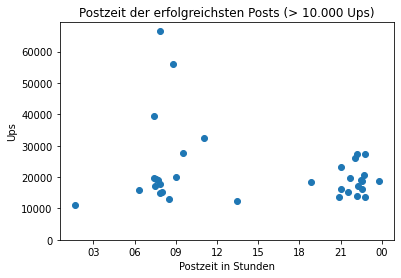

In [11]:
myFmt = pdt.DateFormatter('%H')

plt.scatter(dfr_wodss["time"], dfr_wodss["ups"])
plt.gca().xaxis.set_major_formatter(myFmt)
plt.title("Postzeit der erfolgreichsten Posts (> 10.000 Ups)")
plt.xlabel("Postzeit in Stunden")
plt.ylabel("Ups")
plt.yticks([0,10000,20000,30000,40000,50000,60000])
plt.show()

### 2. Postzeit der schlechtesten Posts (Posts < 10 Ups)

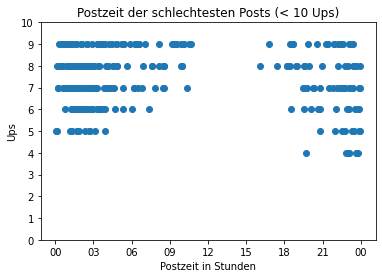

In [12]:
plt.scatter(dfr_wodsl["time"], dfr_wodsl["ups"])
plt.gca().xaxis.set_major_formatter(myFmt)
plt.title("Postzeit der schlechtesten Posts (< 10 Ups)")
plt.xlabel("Postzeit in Stunden")
plt.ylabel("Ups")
plt.yticks([0, 1,2,3,4,5,6,7,8,9,10])
plt.show()

### 3. längste Zeit in Top

In [13]:
dfr_wdg = dfr_wd.groupby("title")
pairs = dfr_wdg.groups

In [14]:
posts = []
for key in pairs:
    posts.append(dfr_wdg.get_group(key)[["time_created", "title", "ups"]].to_dict())

In [15]:
for post in posts:
    post["duration"] = len(post["time_created"]) * REDDIT_SAVE_INTERVALL


In [16]:
duration = []
for post in posts:
    duration.append([list(post["title"].values())[0], 
                     post["duration"], 
                     max(list(post["ups"].values())), 
                     list(post["time_created"].values())[0]])
dfrd = pd.DataFrame(duration, 
                    columns=["title", 
                             "duration_minutes", 
                             "max_ups", 
                             "time_created"])
dfrd_s = dfrd.sort_values("duration_minutes", ascending=False)
dfrd_s["posttime"] = pd.to_datetime(dfrd_s["time_created"])
dfrd_s.head()

,title,duration_minutes,max_ups,time_created,posttime
870,[Homemade] Chocolate Chip Cookies,5640,19340,07:09:46,2021-02-24 07:09:46
1942,[Homemade] Pizza,5540,7254,07:29:14,2021-02-24 07:29:14
1901,[Homemade] Pepperoni Pizza,4750,1195,08:57:17,2021-02-24 08:57:17
695,[Homemade] Charcuterie Board,4690,473,23:23:59,2021-02-24 23:23:59
836,[Homemade] Chili,4620,23092,10:35:58,2021-02-24 10:35:58


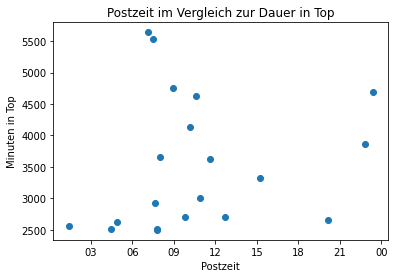

In [17]:
limit = 20
plt.scatter(dfrd_s["posttime"][:limit], dfrd_s["duration_minutes"][:limit])
plt.gca().xaxis.set_major_formatter(myFmt)
plt.title("Postzeit im Vergleich zur Dauer in Top")
plt.xlabel("Postzeit")
plt.ylabel("Minuten in Top")
plt.show()

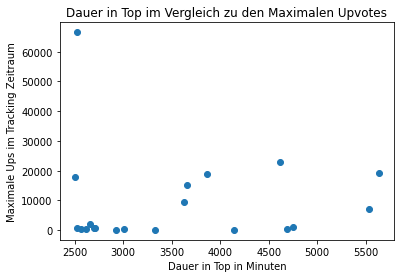

In [18]:
#limit = 20 #nur wenn nochmal verändert werden soll
plt.scatter(dfrd_s["duration_minutes"][:limit], dfrd_s["max_ups"][:limit])
plt.title("Dauer in Top im Vergleich zu den Maximalen Upvotes")
plt.xlabel("Dauer in Top in Minuten")
plt.ylabel("Maximale Ups im Tracking Zeitraum")
plt.show()

### 4. Kürzeste Zeit in Top

In [19]:
dfrd_s[dfrd_s["duration_minutes"] == 10].describe()

,duration_minutes,max_ups
count,120.0,120.000000
mean,10.0,8.850000
std,0.0,3.342243
min,10.0,4.000000
25%,10.0,6.750000
50%,10.0,8.000000
75%,10.0,11.000000
max,10.0,19.000000


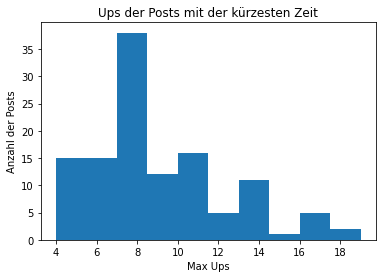

In [20]:
plt.hist(dfrd_s[dfrd_s["duration_minutes"]==10]["max_ups"])
plt.title("Ups der Posts mit der kürzesten Zeit")
plt.xlabel("Max Ups")
plt.ylabel("Anzahl der Posts")
plt.show()

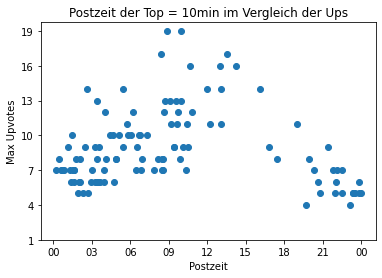

In [21]:
limit = 111
plt.scatter(dfrd_s["posttime"][-limit:], dfrd_s["max_ups"][-limit:])
plt.gca().xaxis.set_major_formatter(myFmt)
plt.title("Postzeit der Top = 10min im Vergleich der Ups")
plt.xlabel("Postzeit")
plt.ylabel("Max Upvotes")
plt.yticks([x for x in range(1,20,3)])
plt.show()

### 5.1 Länge des Titels in Bezug auf Ups

In [22]:
dfr_wods["title_length"] = dfr_wods["title"].apply(len)

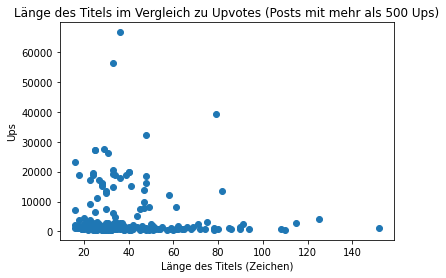

In [23]:
limit = 500
plt.scatter(dfr_wods[dfr_wods["ups"]>limit]["title_length"], 
           dfr_wods[dfr_wods["ups"]>limit]["ups"])
plt.title("Länge des Titels im Vergleich zu Upvotes (Posts mit mehr als " + str(limit) + " Ups)")
plt.xlabel("Länge des Titels (Zeichen)")
plt.ylabel("Ups")
plt.show()

### 5.2. Länge des Titels in Bezug auf Dauer in Top

In [24]:
dfrd_s["title_length"] = dfrd_s["title"].apply(len)

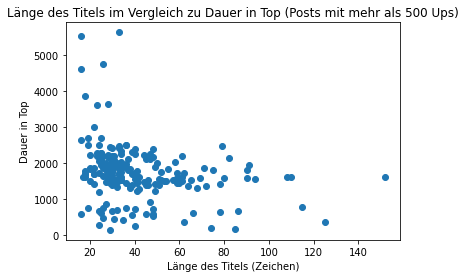

In [25]:
limit = 500
plt.scatter(dfrd_s[dfrd_s["max_ups"]>limit]["title_length"], 
           dfrd_s[dfrd_s["max_ups"]>limit]["duration_minutes"])
plt.title("Länge des Titels im Vergleich zu Dauer in Top (Posts mit mehr als " + str(limit) + " Ups)")
plt.xlabel("Länge des Titels (Zeichen)")
plt.ylabel("Dauer in Top")
plt.show()

### 6. Kategorisierung bzgl. Süß/Herzhaft (NLP)

In [2]:
# von Alex in dedizierten File

### 7. Kategorisierung bzgl. Süß/Herzhaft (Bilderkennung)

### 8. Ups abhängig vom Autor

In [26]:
author_dict = dfr_wods.value_counts(subset=["author"]).to_dict()

In [27]:
authors = []

for key in author_dict:
    author = [key[0], 
              len(dfr_wods[dfr_wods["author"]==key[0]]["ups"].index),
              dfr_wods[dfr_wods["author"]==key[0]]["ups"].sum()]
    authors.append(author)

In [28]:
dfa = pd.DataFrame(authors, columns=["author", "posts", "ups"])
dfa_s = dfa.sort_values("ups", ascending=False)
dfa_s.head()
dfa_ss = dfa_s[dfa_s["ups"]> 10000]

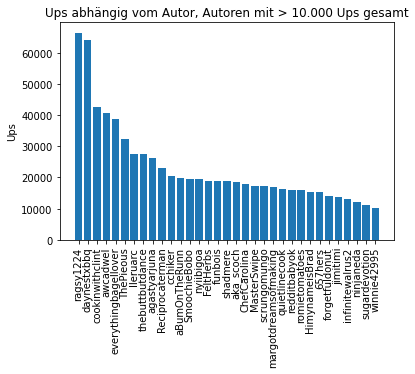

In [29]:
plt.bar(dfa_ss["author"], dfa_ss["ups"])
plt.xticks(rotation='vertical')
plt.title("Ups abhängig vom Autor, Autoren mit > 10.000 Ups gesamt")
plt.ylabel("Ups")
plt.show()

### 8.1. Anzahl Posts pro Autor in Abhängigkeit der Ups gesamt

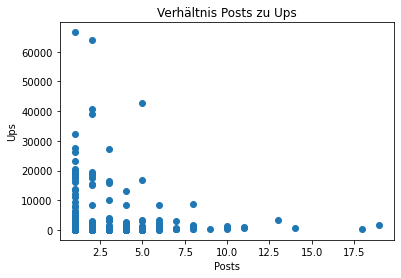

In [30]:
plt.scatter(dfa_s["posts"], dfa_s["ups"])
plt.xlabel("Posts")
plt.ylabel("Ups")
plt.title("Verhältnis Posts zu Ups")
plt.show()

### 9. Anzahl Kommentare in Abhängigkeit von Ups

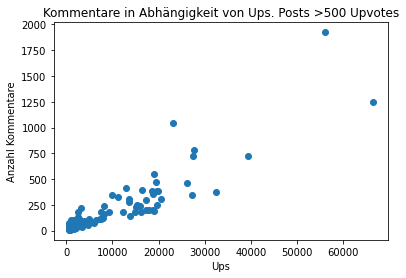

In [31]:
limit = 500
plt.scatter(dfr_wods[dfr_wods["ups"]>limit]["ups"],
           dfr_wods[dfr_wods["ups"]>limit]["num_comments"])
plt.title("Kommentare in Abhängigkeit von Ups. Posts >"+ str(limit) + " Upvotes")
plt.xlabel("Ups")
plt.ylabel("Anzahl Kommentare")
plt.show()

### 10. Anzahl Kommentare in Abhängigkeit von Postzeit

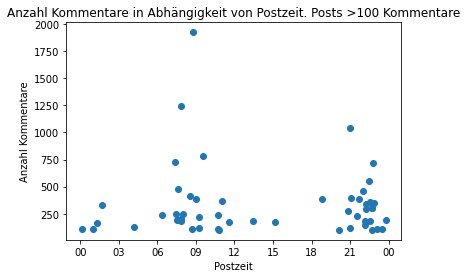

In [32]:
limit = 100
plt.scatter(dfr_wods[dfr_wods["num_comments"]>limit]["time"],
           dfr_wods[dfr_wods["num_comments"]>limit]["num_comments"])
plt.gca().xaxis.set_major_formatter(myFmt)
plt.title("Anzahl Kommentare in Abhängigkeit von Postzeit. Posts >" + str(limit) + " Kommentare")
plt.xlabel("Postzeit")
plt.ylabel("Anzahl Kommentare")
plt.show()

### 11. Anzahl Kommentare in Abhängigkeit vom Autor

In [33]:
authors2 = []

for key in author_dict:
    author = [key[0], 
              len(dfr_wods[dfr_wods["author"]==key[0]]["ups"].index),
              dfr_wods[dfr_wods["author"]==key[0]]["ups"].max(),
             dfr_wods[dfr_wods["author"]==key[0]]["num_comments"].max()]
    authors2.append(author)

In [34]:
authors2[0]

['MaxRamsey', 19, 296, 9]

In [35]:
dfa2 = pd.DataFrame(authors2, columns=["author", "posts", "ups", "num_comments"])
dfa2_s = dfa2.sort_values("num_comments", ascending=False)

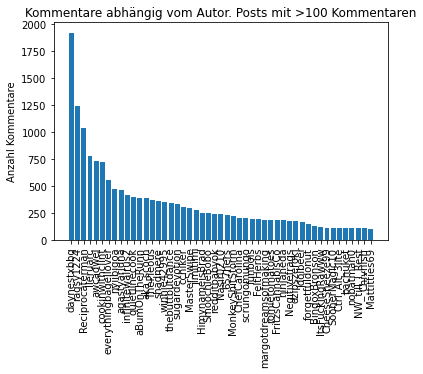

In [36]:
limit = 100
plt.bar(dfa2_s[dfa2_s["num_comments"]>limit]["author"], 
        dfa2_s[dfa2_s["num_comments"]>limit]["num_comments"])
plt.xticks(rotation='vertical')
plt.title("Kommentare abhängig vom Autor. Posts mit >" + str(limit) + " Kommentaren")
plt.ylabel("Anzahl Kommentare")
plt.show()

### 12. Anzahl Kommentare über die Zeit

In [37]:
dfr["time"] = pd.to_datetime(dfr["curr_time"])
critical_date = datetime.now() - timedelta(days=14)

NameError: name 'np' is not defined

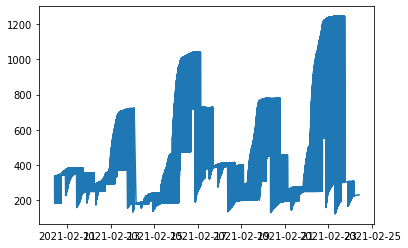

In [38]:
plt.plot(dfr[(dfr["time"]>critical_date) & (dfr["ups"]>10000)]["time"],
        dfr[(dfr["time"]>critical_date) & (dfr["ups"]>10000)]["num_comments"])
color=iter(plt.cm.rainbow(np.linspace(0,1,n)))
for i in range(n):
   c=next(color)

plt.gca().xaxis.set_major_formatter(myFmt)
plt.show()

# --------------------
# Spoonacular
# --------------------
### 16. Anteil vegane/vegetarische/fleischhaltige Gerichte

In [ ]:
dfs_wod = dfs.drop_duplicates(subset=["url"])

In [ ]:
parts = dfs_wod[["vegetarian", "vegan"]].sum()

In [ ]:
fges = dfs_wod["vegetarian"].count()
fvegn = dfs_wod["vegan"].sum()
fvegt = dfs_wod["vegetarian"].sum() - fvegn
frest = fges - fvegt - fvegn

In [ ]:
plt.pie([fvegn, fvegt, frest], 
        labels=["Vegan", "Vegetarisch", "Rest"],
       autopct='%1.1f%%', explode=(0.1,0.1,0.1))
plt.axis('equal')
plt.title("Anteil der Essensrichtung der Spoonacular DB. n=" + str(dfs_wod["dairy_free"].count()))
plt.show()

### 17. Anteil laktosefreie Gerichte

In [ ]:
plt.pie([dfs_wod["dairy_free"].sum(), 
         dfs_wod["dairy_free"].count() - dfs_wod["dairy_free"].sum()], 
        labels=["Laktosefrei", "Nicht Laktosefrei"],
       autopct='%1.1f%%', explode=(0.1,0.1))
plt.axis('equal')
plt.title("Anteil der Laktosefreien Rezepte der Spoonacular DB. n=" + str(dfs_wod["dairy_free"].count()))
plt.show()

### 18. Anteil glutenfreier Gerichte

In [ ]:
plt.pie([dfs_wod["gluten_free"].sum(), 
         dfs_wod["gluten_free"].count() - dfs_wod["gluten_free"].sum()], 
        labels=["Glutenfrei", "Nicht Glutenfrei"],
       autopct='%1.1f%%', explode=(0.1,0.1))
plt.axis('equal')
plt.title("Anteil der Glutenfreien Rezepte der Spoonacular DB. n=" + str(dfs_wod["gluten_free"].count()))
plt.show()

In [ ]:
def filter_category(data):
    counter = {}
    for word in data:
        end = False
        w = ""
        word = word[0].lower()
        for ch in word:
            if end == False:
                if ch == "[":
                    w = w + ch
                elif ch == "]":
                    w = w+ ch
                    end = True
                else:
                    w = w + ch
        if len(w) > 1:
            if w[0] == "[":
                try:
                    counter[w] = counter[w] + 1
                except:
                    counter[w] = 1
    return counter

In [ ]:
x = filter_category(data)

In [ ]:
x

In [ ]:
x = df["hour_created"].value_counts().to_dict()
sorted_hour = []
sorted_counts = []
for elem in sorted(x.items()):
    sorted_hour.append(elem[0])
    sorted_counts.append(elem[1])


In [ ]:
plt.bar(sorted_hour, sorted_counts)

In [ ]:
df["cleaned_text"] = df["title"].apply(str.lower)

In [ ]:
def delete_homemade(text):
    new_text = ""
    old_text = text.split()
    for word in old_text:
        if word[0] != "[":
            if len(new_text) == 0:
                new_text = word
            else:
                new_text = new_text + "," + word
    return new_text

In [ ]:
df["cltext"] = df["cleaned_text"].apply(delete_homemade)

In [ ]:
df.head()

In [ ]:
def getRecipe(suchwort):
    req_url = "https://api.spoonacular.com/recipes/complexSearch?apiKey=" + API_KEY_SPOONACULAR + "&query=" + suchwort + "&number=" + str(LIMIT_SPOONACULAR_RECIPES) + "&addRecipeNutrition=TRUE"
    resp = requests.get(req_url)
    jresp = json.loads(resp.text)
    all_recipes = []
    for recipe in jresp["results"]:
        rlist = [recipe["vegetarian"], 
        recipe["vegan"],
        recipe["glutenFree"],
        recipe["dairyFree"],
        recipe["aggregateLikes"],
        recipe["readyInMinutes"],
        recipe["spoonacularSourceUrl"]]
        
        nutrients = recipe["nutrition"]["nutrients"]
        ingredients = recipe["nutrition"]["ingredients"]
        
        for nutrient in nutrients:
            # Calories, Sugar, Fat, Carbohydrates
            # name, amount, unit
            itemList = ["Calories", "Sugar", "Fat"]
            if nutrient["name"] in itemList:
                rlist.append(nutrient["amount"])
                
        ilist = []
        for ingredient in ingredients:
            # name
            ilist.append(ingredient["name"])
        rlist.append(ilist)

        all_recipes.append(rlist)
    return all_recipes    

In [ ]:
x = getRecipe("raspberry")

In [ ]:
x

### Get random recipes from spoonacular

In [ ]:
req_url = "https://api.spoonacular.com/recipes/random?apiKey=" + API_KEY_SPOONACULAR + "&number=" + str(LIMIT_SPOONACULAR_RECIPES) + "&addRecipeNutrition=TRUE"

In [ ]:
resp = requests.get(req_url)
jresp = json.loads(resp.text)

In [ ]:
for recipe in jresp["recipes"]:
    print(recipe)
    break
    print(recipe["aggregateLikes"])
    print(recipe["spoonacularSourceUrl"])

In [ ]:
datetime.now()

### Handle data from database

In [ ]:
# remember ndf? now let's analyze
ndf.head()

In [ ]:
# title, ups, curr_time
x= ndf[ndf["title"] == "[Homemade] Chocolate Chip Cookies"]

In [ ]:
x["curr_time"] = pd.to_datetime(x["curr_time"])


In [ ]:
plt.plot(x["curr_time"], x["ups"])

In [ ]:
x["time_created"]

In [ ]:
def get_uniques(title):
    data = ndf[ndf["title"] == title]
    dataDf = data[["title", "ups", "curr_time"]]
    return dataDf.values.tolist()

In [ ]:
ndf["toFilter"] = ndf["title"].apply(get_uniques) # vorsicht dauert lange

In [ ]:
blub = ndf["toFilter"].iloc[1]

In [ ]:
blubDf = pd.DataFrame(blub, columns=["title", "ups", "curr_time"])
blubDf["time"] = pd.to_datetime(blubDf["curr_time"])

In [ ]:
plt.plot(blubDf["time"], blubDf["ups"])

In [ ]:
sorted = ndf.sort_values(['title', 'id'], ascending = [True, False])

first = sorted.groupby('title').first().reset_index()

In [ ]:
for i in range(1,50):
    blub = first["toFilter"].iloc[i]
    blubDf = pd.DataFrame(blub, columns=["title", "ups", "curr_time"])
    blubDf["time"] = pd.to_datetime(blubDf["curr_time"])
    plt.plot(blubDf["time"], blubDf["ups"])
plt.yscale('log') # logarithmische Skalierung
plt.show()

In [ ]:
maxVal = {"title": "", "ups": 0}
for i in range(1, len(ndf["title"])):
    pass

In [ ]:
first[first["title"] == [first["ups"]==first["ups"].max()]]

In [ ]:
first[first["ups"]==first["ups"].min()]

In [ ]:
def getRecipeByCuisine(cuisine):
    req_url = "https://api.spoonacular.com/recipes/complexSearch?apiKey=" + API_KEY_SPOONACULAR + "&cuisine=" + cuisine + "&number=" + str(LIMIT_SPOONACULAR_RECIPES) + "&addRecipeNutrition=TRUE&offset=400"
    resp = requests.get(req_url)
    jresp = json.loads(resp.text)
    all_recipes = []
    for recipe in jresp["results"]:
        rlist = [recipe["vegetarian"], 
        recipe["vegan"],
        recipe["glutenFree"],
        recipe["dairyFree"],
        recipe["aggregateLikes"],
        recipe["readyInMinutes"],
        recipe["spoonacularSourceUrl"]]
        
        nutrients = recipe["nutrition"]["nutrients"]
        ingredients = recipe["nutrition"]["ingredients"]
        
        for nutrient in nutrients:
            # Calories, Sugar, Fat, Carbohydrates
            # name, amount, unit
            itemList = ["Calories", "Sugar", "Fat"]
            if nutrient["name"] in itemList:
                rlist.append(nutrient["amount"])
                
        #ilist = []
        ilist = {}
        for i, ingredient in enumerate(ingredients):
            # name
            ilist[i] = ingredient["name"]
            #ilist.append(ingredient["name"])
        rlist.append(ilist)

        rlist.append(recipe["title"])
        all_recipes.append(rlist)
    return all_recipes    

In [ ]:
db_connection = mysql.connector.connect(
  host= "wp.jagi.wtf",
  user= "redditu",
  password= "redditMaster",
  database="reddit"
  )

In [ ]:
cursor = db_connection.cursor()

In [ ]:
cuisines = ["African", "American", "British", "Cajun", "Caribbean", "Chinese", "Eastern European", "European", "French", "German","Greek", "Indian", "Irish", "Italian", "Japanese", "Jewish", "Korean", "Latin American", "Mediterranean","Mexican", "Middle Eastern", "Nordic", "Southern", "Spanish", "Thai", "Vietnamese"]
cuisines = ["European"]
#cuisines = ["Eastern European"]
for i, cuisine in enumerate(cuisines):
    recipes = getRecipeByCuisine(cuisine)
    for recipe in recipes:
        query = "INSERT INTO spoonacular (vegetarian,vegan, gluten_free, dairy_free,likes, ready_in_minutes, url, calories, sugar, fat, ingredients, cuisine, title) VALUES(%s, %s, %s,%s, %s, %s,%s, %s, %s,%s, %s, %s, %s)"
        vals = (str(int(recipe[0])), str(int(recipe[1])), str(int(recipe[2])),str(int(recipe[3])),
               str(recipe[4]), str(recipe[5]), str(recipe[6]), str(recipe[7]), str(recipe[8]), str(recipe[9]),
               json.dumps(recipe[10]), cuisine, str(recipe[11]))
        cursor.execute(query, vals)
    db_connection.commit()

In [ ]:
db_connection.commit()

In [ ]:
cuisines = ["African", "American", "British", "Cajun", "Caribbean", "Chinese", "Eastern European", "European", "French", "German","Greek", "Indian", "Irish", "Italian", "Japanese", "Jewish", "Korean", "Latin American", "Mediterranean","Mexican", "Middle Eastern", "Nordic", "Southern", "Spanish", "Thai", "Vietnamese"]
print(cuisines[7:])

In [ ]:
req_url

In [ ]:
def getRecipeByType(cuisine):
    req_url = "https://api.spoonacular.com/recipes/complexSearch?apiKey=" + API_KEY_SPOONACULAR + "&type=" + cuisine + "&number=" + str(LIMIT_SPOONACULAR_RECIPES) + "&addRecipeNutrition=TRUE&offset=900"
    resp = requests.get(req_url)
    jresp = json.loads(resp.text)
    all_recipes = []
    for recipe in jresp["results"]:
        rlist = [recipe["vegetarian"], 
        recipe["vegan"],
        recipe["glutenFree"],
        recipe["dairyFree"],
        recipe["aggregateLikes"],
        recipe["readyInMinutes"],
        recipe["spoonacularSourceUrl"]]
        
        nutrients = recipe["nutrition"]["nutrients"]
        ingredients = recipe["nutrition"]["ingredients"]
        
        for nutrient in nutrients:
            # Calories, Sugar, Fat, Carbohydrates
            # name, amount, unit
            itemList = ["Calories", "Sugar", "Fat"]
            if nutrient["name"] in itemList:
                rlist.append(nutrient["amount"])
                
        #ilist = []
        ilist = {}
        for i, ingredient in enumerate(ingredients):
            # name
            ilist[i] = ingredient["name"]
            #ilist.append(ingredient["name"])
        rlist.append(ilist)

        rlist.append(recipe["title"])
        all_recipes.append(rlist)
    return all_recipes    

In [ ]:
types = ["main course",
        "side dish",
        "dessert",
        "appetizer",
        "salad",
        "bread",
        "breakfast",
        "soup",
        "beverage",
        "sauce",
        "marinade",
        "fingerfood",
        "snack",
        "drink"]

types = ["main course",
        "side dish"]

#cuisines = ["Eastern European"]
for i, typ in enumerate(types):
    recipes = getRecipeByType(typ)
    for recipe in recipes:
        query = "INSERT INTO spoonacular (vegetarian,vegan, gluten_free, dairy_free,likes, ready_in_minutes, url, calories, sugar, fat, ingredients, type, title) VALUES(%s, %s, %s,%s, %s, %s,%s, %s, %s,%s, %s, %s, %s)"
        vals = (str(int(recipe[0])), str(int(recipe[1])), str(int(recipe[2])),str(int(recipe[3])),
               str(recipe[4]), str(recipe[5]), str(recipe[6]), str(recipe[7]), str(recipe[8]), str(recipe[9]),
               json.dumps(recipe[10]), typ, str(recipe[11]))
        cursor.execute(query, vals)
    db_connection.commit()

In [ ]:
cursor.execute("SELECT * FROM spoonacular")
data = cursor.fetchall()

In [ ]:
df = pd.DataFrame(data, columns=["id", "vegetarian", "vegan", "gluten_free", "dairy_free","likes", "ready_in_minutes", "url", "calories", "sugar", "fat","ingredients", "cuisine", "title", "typ"])

In [ ]:
df.head()

In [ ]:
df[["vegetarian", "vegan", "gluten_free", "dairy_free"]].sum()

In [ ]:
df.drop_duplicates(subset ="title", 
                     keep = False, inplace = True)

In [ ]:
df.describe()